# Modeling with TensorFlow


In [1]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
  %tensorflow_version 2.x
except:
  IN_COLAB = False

TensorFlow 2.x selected.


In [2]:
if IN_COLAB:
    !pip install imageai
    from google.colab import drive
    drive.mount('/content/gdrive')

     |████████████████████████████████| 184kB 3.4MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
import cv2 as cv
from imageai.Detection import ObjectDetection
import os
import random, math

Using TensorFlow backend.


In [0]:
if IN_COLAB:
    tf.test.gpu_device_name()
    # need to use gpu runtime accelerator!
    mirrored_strategy = tf.distribute.MirroredStrategy()

# Create generator


In [5]:
!pwd

/content


In [6]:
if IN_COLAB:
    os.chdir(f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(os.path.expanduser(f'~/Google Drive/thinkful/colab_datasets/sidewalk_data/images/'))
!pwd

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images


In [0]:
#move images into train, test, validate folders with subfolders for classes
test_ratio = .15
SPLIT_DATA = False # switch if need to divide out data
if SPLIT_DATA:
    for label in ['sidewalk', 'no_sidewalk']:
        %cd ./$label
        listing = os.popen('ls').read().strip().split(sep='\n')
        random.shuffle(listing) #inplace
        im_count = len(listing)
        test_size=val_size = math.ceil(test_ratio*im_count)
        train_size = im_count - test_size
        subfolders = ['train', 'test'] #train will be used for vdation too
        for subfolder in subfolders:
            os.makedirs(os.path.join(
                os.path.dirname(os.getcwd()), subfolder, label))
        for item in range(0, train_size):
            moved = listing.pop()
            !mv $moved ../train/$label/$moved
        for item in range(0, test_size):
            moved = listing.pop()
            !mv $moved ../test/$label/$moved
        %cd ..
        !rmdir ./$label

### Parameters for data loading

In [0]:
idg_params={'rescale': 1./255}
batch_size=64
augmentation_params = {'rotation_range': 15,
                        'zoom_range': 0.15,
                         'width_shift_range': 0.2,
                         'height_shift_range': 0.2,
                         'shear_range': 0.15,
                         'fill_mode': 'nearest',
                         'horizontal_flip': True}
datagen_params = {'batch_size': batch_size,
                  'target_size': (224, 224),
                  'color_mode': 'rgb', 
                  'class_mode': 'binary'}

In [0]:
train_vdate_datagen = ImageDataGenerator(
    **idg_params,
    validation_split=0.2)
train_augmented_datagen = ImageDataGenerator(
    **idg_params,
    **augmentation_params,
    validation_split=0.2)
test_datagen = ImageDataGenerator(**idg_params)

In [29]:
# Flow training images in batches of 128 using train_datagen generator
vdate_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='validation',
        **datagen_params)
train_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='training',
        **datagen_params)
test_generator = test_datagen.flow_from_directory(
        directory=r'./test/',
        **datagen_params)

Found 795 images belonging to 2 classes.
Found 3186 images belonging to 2 classes.
Found 1219 images belonging to 2 classes.


### Parameters for Modeling

In [0]:
n_epochs = 25
learning_rate = 0.000001
loss = 'binary_crossentropy'

In [31]:
pwd

'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images'

In [32]:
imagecount = {}
sidewalk_image_count = ! cd ./train/sidewalk/ && ls | wc -l
no_sidewalk_image_count = ! cd ./train/no_sidewalk/ && ls | wc -l
imagecount['sidewalk'] = int(sidewalk_image_count.nlstr)
imagecount['no_sidewalk'] = int(no_sidewalk_image_count.nlstr)
imagecount['total'] = imagecount['sidewalk'] + imagecount['no_sidewalk']

print(imagecount)

{'sidewalk': 3007, 'no_sidewalk': 974, 'total': 3981}


In [33]:
#adjust weights to equivalent between classes
class_weight = {}
class_weight['sidewalk'] = (
    .5 / imagecount['sidewalk']) * imagecount['total']
class_weight['no_sidewalk'] = (
    .5 / imagecount['no_sidewalk']) * imagecount['total']
class_weight

{'no_sidewalk': 2.043634496919918, 'sidewalk': 0.6619554373129365}

In [34]:
class_id = train_generator.class_indices
#class ids are floats
class_id = {key: float(value) for (key,value) in class_id.items()}
class_id

{'no_sidewalk': 0.0, 'sidewalk': 1.0}

In [35]:
class_weight[class_id['sidewalk']] = class_weight.pop('sidewalk')
class_weight[class_id['no_sidewalk']] = class_weight.pop('no_sidewalk')
class_weight

{0.0: 2.043634496919918, 1.0: 0.6619554373129365}

In [36]:
#generator based caluculations
input_shape = train_generator.next()[0].shape[1:]
total_train_samples = train_generator.n
total_vdate_samples = vdate_generator.n
input_shape

(224, 224, 3)

### Setup Metrics and Visualizations

Use Matthew Correlation Coefficient to take into account all four quadrants of confusion matrix.

In [0]:
# if y_pred > threshold we predict true. 
# Sometimes we set this to something different to 0.5 if we have unbalanced categories
threshold = 0.5  
def matthews_correlation(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [0]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      matthews_correlation]

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def history_plotter(history, n_epochs=n_epochs, plot_validation=True): 
    '''plot the training loss and accuracy
    plot_validation exists because valdation not working in model
    '''
    n_epochs_range = np.arange(0, n_epochs)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                                  figsize=(10,5))
    ax1.plot(n_epochs_range, history.history["loss"], label="Loss")
    ax1.plot(n_epochs_range, history.history["accuracy"], label="Accuracy")
    ax1.plot(n_epochs_range, history.history['auc'], label='Area Under ROC')
    ax1.plot(n_epochs_range, history.history['matthews_correlation'], label="Matthews Coef")
    if plot_validation:
        ax2.plot(n_epochs_range, history.history["val_loss"], label="loss")
        ax2.plot(n_epochs_range, history.history["val_accuracy"], label="Accuracy")
        ax2.plot(n_epochs_range, history.history["val_auc"], label="Area Under ROC")
        ax2.plot(n_epochs_range, history.history["val_matthews_correlation"], label="Matthews Coef")
    
    ax1.set_title("Training Metrics")
    ax2.set_title("Validation Metrics")
    plt.xlabel("Epoch #")
    ax1.set_ylabel("Metric Score")
    ax1.legend(); ax2.legend()
    plt.plot();

In [20]:
METRICS

 <function __main__.matthews_correlation>]

### Convolutional Model

In [53]:
conv_model = tf.keras.models.Sequential()
conv_model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=input_shape))
conv_model.add(MaxPooling2D(pool_size=(3, 3)))
conv_model.add(Dropout(0.5))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.5))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(32, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              metrics=METRICS)
conv_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 78400)            

In [54]:
conv_history = conv_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=False,
        class_weight=class_weight)

Epoch 1/25
49/49 [==============================] - 28s 567ms/step - loss: 0.7198 - accuracy: 0.5442 - auc: 0.4910 - matthews_correlation: -0.0192 - val_loss: 0.6880 - val_accuracy: 0.7083 - val_auc: 0.5295 - val_matthews_correlation: -0.0093
Epoch 2/25
49/49 [==============================] - 28s 573ms/step - loss: 0.7070 - accuracy: 0.5436 - auc: 0.5077 - matthews_correlation: 0.0102 - val_loss: 0.6905 - val_accuracy: 0.6393 - val_auc: 0.5701 - val_matthews_correlation: 0.0813
Epoch 3/25
49/49 [==============================] - 28s 568ms/step - loss: 0.7083 - accuracy: 0.5384 - auc: 0.5073 - matthews_correlation: 0.0144 - val_loss: 0.6910 - val_accuracy: 0.6354 - val_auc: 0.5935 - val_matthews_correlation: 0.1183
Epoch 4/25
49/49 [==============================] - 27s 561ms/step - loss: 0.7074 - accuracy: 0.5324 - auc: 0.5100 - matthews_correlation: 0.0326 - val_loss: 0.6898 - val_accuracy: 0.7070 - val_auc: 0.5663 - val_matthews_correlation: 0.1295
Epoch 5/25
49/49 [================

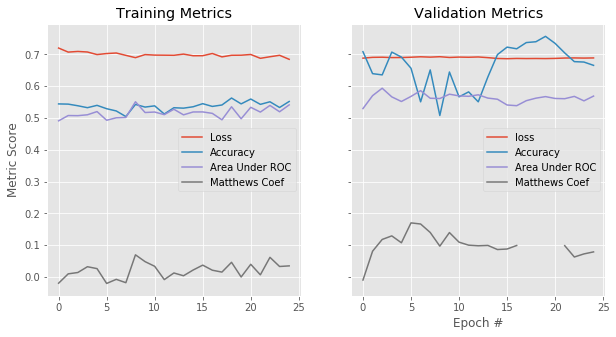

In [55]:
history_plotter(history=conv_history, plot_validation=True)

# Object Detection via Transfer Learning


In [0]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')
pretrained_mobilenet.trainable = False

In [47]:
mnet_lr = .000_01
mnet_model = tf.keras.models.Sequential()
mnet_model.add(pretrained_mobilenet)
mnet_model.add(tf.keras.layers.GlobalAveragePooling2D())
mnet_model.add(tf.keras.layers.Dense(64))
mnet_model.add(tf.keras.layers.Dropout(.5))
mnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

mnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=mnet_lr),
              loss=loss,
              metrics=METRICS)
mnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                81984     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
mnet_history = mnet_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=25,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        class_weight=class_weight,
        use_multiprocessing=False)

Epoch 1/25
49/49 [==============================] - 33s 683ms/step - loss: 0.8133 - accuracy: 0.5503 - auc: 0.5651 - matthews_correlation: 0.0744 - val_loss: 0.6381 - val_accuracy: 0.6445 - val_auc: 0.5562 - val_matthews_correlation: 0.0619
Epoch 2/25
49/49 [==============================] - 33s 673ms/step - loss: 0.7784 - accuracy: 0.5788 - auc: 0.5907 - matthews_correlation: 0.1178 - val_loss: 0.6124 - val_accuracy: 0.6719 - val_auc: 0.5882 - val_matthews_correlation: 0.0945
Epoch 3/25
49/49 [==============================] - 33s 675ms/step - loss: 0.7601 - accuracy: 0.5987 - auc: 0.6127 - matthews_correlation: 0.1423 - val_loss: 0.6027 - val_accuracy: 0.6732 - val_auc: 0.6123 - val_matthews_correlation: 0.1079
Epoch 4/25
49/49 [==============================] - 33s 683ms/step - loss: 0.7101 - accuracy: 0.6268 - auc: 0.6565 - matthews_correlation: 0.1935 - val_loss: 0.6122 - val_accuracy: 0.6706 - val_auc: 0.6318 - val_matthews_correlation: 0.1447
Epoch 5/25
49/49 [==================

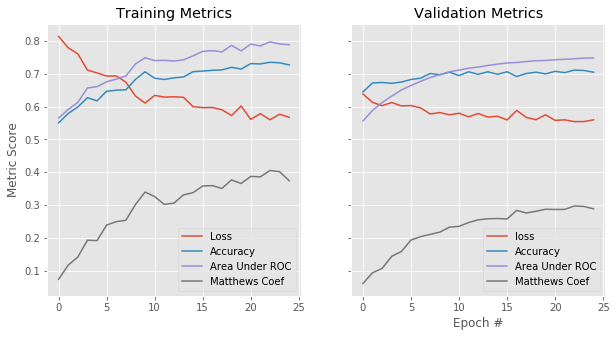

In [49]:
history_plotter(mnet_history)

In [50]:
pretrained_xception = tf.keras.applications.Xception(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')
pretrained_xception.trainable = False

xc_lr = .000_01
xc_model = tf.keras.models.Sequential()
xc_model.add(pretrained_xception)
xc_model.add(tf.keras.layers.GlobalAveragePooling2D())
xc_model.add(tf.keras.layers.Dense(64))
xc_model.add(tf.keras.layers.Dropout(.5))
xc_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

xc_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=xc_lr),
              loss=loss,
              metrics=METRICS)
xc_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 20,992,681
Trainable params: 131,201
Non-trainable params: 20,861,480
_________________________________________________________________


In [51]:
xc_epochs = 25
xc_history = xc_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=xc_epochs,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        class_weight=class_weight,
        use_multiprocessing=False)

Epoch 1/25
49/49 [==============================] - 47s 952ms/step - loss: 0.7095 - accuracy: 0.5916 - auc: 0.5408 - matthews_correlation: 0.0324 - val_loss: 0.5884 - val_accuracy: 0.7630 - val_auc: 0.6600 - val_matthews_correlation: 0.1767
Epoch 2/25
49/49 [==============================] - 46s 934ms/step - loss: 0.6923 - accuracy: 0.5666 - auc: 0.5708 - matthews_correlation: 0.1019 - val_loss: 0.5861 - val_accuracy: 0.7617 - val_auc: 0.6934 - val_matthews_correlation: 0.2324
Epoch 3/25
49/49 [==============================] - 46s 932ms/step - loss: 0.6789 - accuracy: 0.5967 - auc: 0.6117 - matthews_correlation: 0.1470 - val_loss: 0.5785 - val_accuracy: 0.7604 - val_auc: 0.7181 - val_matthews_correlation: 0.2429
Epoch 4/25
49/49 [==============================] - 46s 934ms/step - loss: 0.6515 - accuracy: 0.6348 - auc: 0.6585 - matthews_correlation: 0.2100 - val_loss: 0.5614 - val_accuracy: 0.7695 - val_auc: 0.7340 - val_matthews_correlation: 0.2651
Epoch 5/25
49/49 [==================

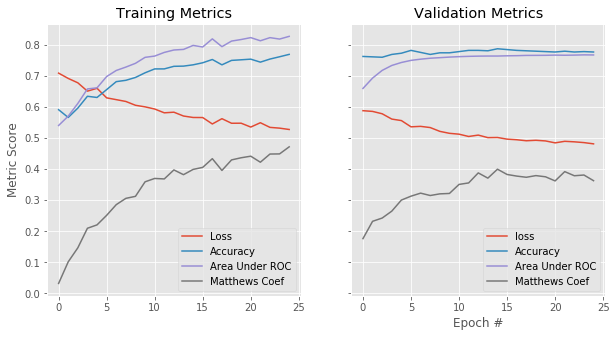

In [52]:
history_plotter(xc_history, n_epochs=xc_epochs)

# Object Segmentation
This will use a pretrained model as the basis for a nn that identifies the part of an image file that contains the sidewalk object.

### tinyYOLOv3

In [0]:
model_path = "./models/yolo-tiny.h5"
input_path = "./input/test45.jpg"
output_path = "./output/newimage.jpg"

In [0]:
detector = ObjectDetection().get
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()

#returns dictionary with name and probabilities of objects detected
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

RuntimeError: `get_session` is not available when using TensorFlow 2.0.

In [0]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = SentimentService.get_model1()
#New code to load model
def load_deep_model(self, model):
        loaded_model = tf.keras.models.load_model("./src/mood-saved-models/"model + ".h5")
        return loaded_model
    
    
    detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()

#returns dictionary with name and probabilities of objects detected
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

### MobileNetV2




In [0]:
xcept_model = tf.keras.applications.Xception(weights='imagenet')
#http://download.tensorflow.org/models/deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz
